# Import libraries

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import unittest
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn 
from sklearn import linear_model
import statsmodels.api as sm
import requests 
import json
from operator import itemgetter
from multiprocessing import Pool

# Data acquisition

## API  

**Youtube**

Recherche de la playlist avec les artistes qui montent
Requete 'rising artists'

En sortie playlistId qui nou dirige vers une page avec la liste des artistes

In [6]:
website_prefixs = "https://www.googleapis.com/youtube/v3/search?"
website_prefixs = website_prefixs + "part={}&maxResults={}&q={}&order={}&type={}&key={}"
apikey = 'xxxxxxxxxxxxxxx'
apiparts = 'snippet'
apimaxResultss = 5
apiQs='rising artists'
apiorders='viewCount'
apitypes='playlist'
apiurls = website_prefixs.format(apiparts, apimaxResultss, apiQs, apiorders, apitypes, apikey)
#apiurls

In [7]:
reqs = requests.get(apiurls)
json_ress = json.loads(reqs.text)

In [8]:
# Get the playlistID
apiplaylistId=json_ress['items'][0]['id']['playlistId']

Recuperer la liste des artistes à partir de la playlist 'rising artists'

In [9]:
website_prefix = "https://www.googleapis.com/youtube/v3/playlistItems?"
website_prefix = website_prefix + "part={}&maxResults={}&playlistId={}&key={}"
apikey = 'xxxxxxxxxxxxx'
apipart = 'snippet,contentDetails'
apimaxResults = 20
apiurl = website_prefix.format(apipart, apimaxResults, apiplaylistId, apikey)
#apiurl

In [155]:
req = requests.get(apiurl)
json_res = json.loads(req.text)

In [157]:
#json_res

# Exploring and cleaning data

In [178]:
titles = list(map(lambda x : x['snippet']['title'], json_res['items']))
#titles

In [179]:
df = pd.DataFrame(titles)
df.columns = ['Initial']
df['Artist'] = df['Initial'].str.replace(r'\-.*','')\
                            .str.replace(r':.*','').map(lambda x: x.strip())
# Extract song title
df['Title'] = df['Initial'].str.replace(r'.*\-','')\
                            .str.replace(r'\(.*\)','')\
                            .str.replace(r'\[.*\]','')\
                            .str.replace(r'.*:','').map(lambda x: x.strip())

In [180]:
# Drop column
df = df.drop(columns=['Initial'])

In [181]:
df.head()

,Artist,Title
0,Ava Max,Sweet but Psycho
1,Noah Kahan,False Confidence
2,Roddy Ricch,Die Young
3,Mick Jenkins,Understood
4,DaniLeigh,Lil Bebe


In [182]:
# Write transformed data set to CSV
raising_artists_file = 'raising_artists.csv'
df.to_csv(raising_artists_file, sep=',', index=False)

## Model de prediction

On essaie d'estimer les ventes sur l'année prochaine

### Load Train Data


In [190]:
file = 'trainsets.xlsx'
df_train = pd.read_excel(file, sheet_name='BestHits')
cols = ['Id', 'Artiste', 'Titre', 'Année', 'Ventes', 'danceability',
       'energy', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo']
df_train = df_train[cols]  

In [191]:
df_train.head()

,Id,Artiste,Titre,Année,Ventes,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,Elton John,Candle in the Wind 1997,1997,33.0,0.533,0.1110,4,1,0.0449,0.955,0.672000,0.0975,0.222,125.477
1,2,Mungo Jerry,In the Summertime,1970,30.0,0.754,0.4490,4,1,0.0615,0.724,0.000000,0.1620,0.973,82.751
2,3,Bing Crosby,Silent Night,1935,30.0,0.111,0.1840,8,1,0.0344,0.974,0.045600,0.1110,0.214,76.416
3,4,Bill Haley,Rock Around the Clock,1954,25.0,0.609,0.5260,9,1,0.4300,0.139,0.000000,0.0946,0.930,173.179
4,5,Domenico Modugno,Nel blu dipinto di blu,1958,22.0,0.547,0.0588,10,1,0.0405,0.982,0.000016,0.1930,0.481,129.510


### Load Train Data

In [193]:
file = 'trainsets.xlsx'
df_test = pd.read_excel(file, sheet_name='Youngs')
cols = ['Id', 'artistsrc', 'titlesrc', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']
df_test = df_test[cols]  

In [194]:
df_test.head()

,Id,artistsrc,titlesrc,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,Ava Max,Sweet but Psycho,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.000000,0.166,0.6280,133.002
1,2,Noah Kahan,False Confidence,0.417,0.673,6,-7.719,1,0.0497,0.1990,0.000000,0.128,0.3140,108.994
2,3,Roddy Ricch,Die Young,0.688,0.642,4,-5.567,0,0.3210,0.2210,0.000000,0.200,0.3410,160.319
3,4,Mick Jenkins,Understood,0.664,0.842,9,-5.351,1,0.3390,0.2060,0.000006,0.554,0.7190,84.994
4,5,DaniLeigh,Lil Bebe,0.832,0.485,1,-4.521,1,0.0860,0.0479,0.000000,0.111,0.0721,136.039


### Prepare X_train and X_test

In [196]:
new_train = df_train.copy()
# Drop columns
columns = ['Id', 'Artiste', 'Titre', 'Année', 'Ventes']
new_train.drop(columns, inplace=True, axis=1)
new_train.head()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.533,0.1110,4,1,0.0449,0.955,0.672000,0.0975,0.222,125.477
1,0.754,0.4490,4,1,0.0615,0.724,0.000000,0.1620,0.973,82.751
2,0.111,0.1840,8,1,0.0344,0.974,0.045600,0.1110,0.214,76.416
3,0.609,0.5260,9,1,0.4300,0.139,0.000000,0.0946,0.930,173.179
4,0.547,0.0588,10,1,0.0405,0.982,0.000016,0.1930,0.481,129.510


In [197]:
classes  = df_train['Ventes']

In [205]:
new_test = df_test.copy()
# Drop columns
columns = ['Id', 'artistsrc', 'titlesrc','loudness']
new_test.drop(columns, inplace=True, axis=1)
new_test.head()

,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.719,0.704,1,1,0.0476,0.0691,0.000000,0.166,0.6280,133.002
1,0.417,0.673,6,1,0.0497,0.1990,0.000000,0.128,0.3140,108.994
2,0.688,0.642,4,0,0.3210,0.2210,0.000000,0.200,0.3410,160.319
3,0.664,0.842,9,1,0.3390,0.2060,0.000006,0.554,0.7190,84.994
4,0.832,0.485,1,1,0.0860,0.0479,0.000000,0.111,0.0721,136.039


In [209]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(new_train, classes)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [210]:
y_test_pred = rf.predict(new_test)

In [212]:
df_pred = df_test['artistsrc']

In [216]:
y_test_pred

array([ 6.3 ,  6.1 ,  6.6 ,  7.5 , 11.65,  6.8 ,  7.7 ,  8.9 ,  7.  ,
        7.  ,  6.25,  5.95, 10.2 ,  6.95,  7.55,  7.25,  8.05,  7.1 ,
        6.45,  9.  ])

In [226]:
df_pred = pd.DataFrame(y_test_pred)
df_pred.columns = ['PredVentes']
df_pred['RaisingArtiste'] = df_test['artistsrc']

In [227]:
df_pred = df_pred.sort_values('PredVentes', ascending = False)

In [228]:
df_pred

,PredVentes,RaisingArtiste
4,11.65,DaniLeigh
12,10.20,Burna Boy
19,9.00,tobi lou
7,8.90,flora cash
16,8.05,Bryant Myers
6,7.70,Elle King
14,7.55,for KING COUNTRY
3,7.50,Mick Jenkins
15,7.25,Bri Steves
17,7.10,The Struts


In [229]:
#Always call fit on the estimator before invoking this method. 
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    for f in range(col_array.shape[1]-1): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()

Top Important Features
 Features utilisée
1. valence (0.210886)
2. energy (0.208065)
3. danceability (0.156794)
4. liveness (0.119944)
5. speechiness (0.117414)
6. acousticness (0.068184)
7. key (0.062952)
8. tempo (0.025925)
9. instrumentalness (0.022961)

Mean Feature Importance  0.1


<IPython.core.display.Javascript object>


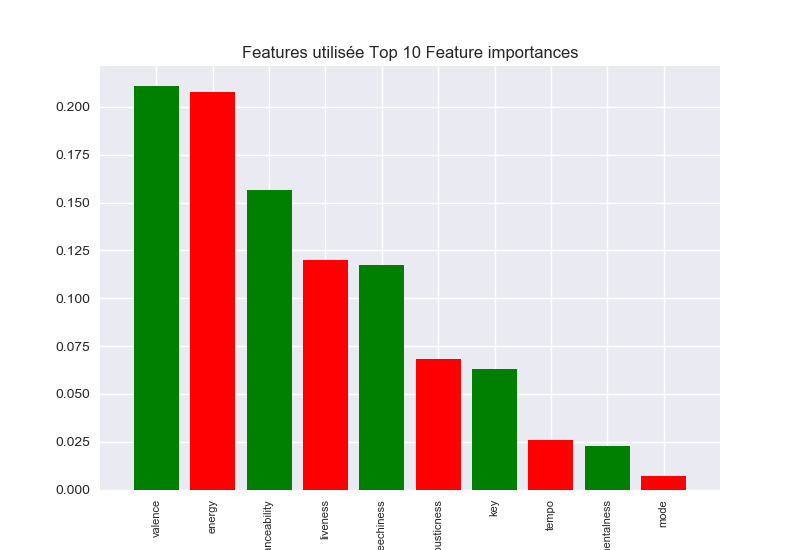

In [230]:
importances(rf, new_train, "Features utilisée")

# Direct answer to the questions thanks to the models

## Question 1 

## Question 2 

## Question 3

# Conclusion